In [4]:
# ✅ Basic Data Handling
import pandas as pd
import numpy as np
import os

# ✅ File Upload (Colab-specific)
from google.colab import files

# ✅ Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb

# ✅ Display settings
import warnings
warnings.filterwarnings('ignore')

# ✅ Plot settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)


In [5]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost openpyxl


In [6]:
from google.colab import files
uploaded = files.upload()


Saving bom.csv to bom (1).csv
Saving forecast_actuals.csv to forecast_actuals (1).csv
Saving on_hand_inventory.csv to on_hand_inventory (1).csv
Saving products.csv to products (1).csv
Saving supplier_bom.csv to supplier_bom (1).csv


In [7]:
import os

# List all uploaded files
os.listdir()


['.config',
 'forecast_actuals.csv',
 'on_hand_inventory (1).csv',
 'on_hand_inventory.csv',
 'bom.csv',
 'supplier_bom (1).csv',
 'forecast_actuals (1).csv',
 'products.csv',
 'supplier_bom.csv',
 'products (1).csv',
 'bom (1).csv',
 'sample_data']

In [8]:


bom = pd.read_csv('bom.csv')
forecast_actuals = pd.read_csv('forecast_actuals.csv')
on_hand_inventory = pd.read_csv('on_hand_inventory.csv')
products = pd.read_csv('products.csv')
supplier_bom = pd.read_csv('supplier_bom.csv')



In [9]:
# Step 4: Forecast Accuracy Overview

# Calculate absolute forecast error for each week
forecast_actuals['forecast_error'] = abs(
    forecast_actuals['ForecastedDemand'] - forecast_actuals['ActualDemand']
)

# Group by ProductID to get total forecasted, actual, and average error
forecast_summary = forecast_actuals.groupby('ProductID').agg({
    'ForecastedDemand': 'sum',
    'ActualDemand': 'sum',
    'forecast_error': 'mean'
}).reset_index()

# Calculate Forecast Accuracy %
forecast_summary['forecast_accuracy_%'] = 100 * (
    1 - forecast_summary['forecast_error'] / forecast_summary['ActualDemand']
)

# View the result
forecast_summary.head()


,ProductID,ForecastedDemand,ActualDemand,forecast_error,forecast_accuracy_%
0,1,1446,2239,74.846154,96.657162
1,2,1673,1554,48.384615,96.886447
2,3,1651,1354,91.307692,93.256448
3,4,1551,1599,47.076923,97.055852
4,5,1800,1807,45.153846,97.501171


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Use ProductID, Week, and ForecastedDemand to predict ActualDemand
df = forecast_actuals.copy()

# Optional: One-hot encode ProductID if needed
X = df[['ProductID', 'Week', 'ForecastedDemand']]
y = df['ActualDemand']

# Encoding ProductID (categorical) + use numeric columns as-is
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['ProductID']),
    ('num', 'passthrough', ['Week', 'ForecastedDemand'])
])

# Linear Regression pipeline
linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
linreg_pipeline.fit(X_train, y_train)
y_pred_lin = linreg_pipeline.predict(X_test)

# Evaluate
print("🔵 Linear Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred_lin))
print("R2 Score:", r2_score(y_test, y_pred_lin))


🔵 Linear Regression Results:
MSE: 3085.616380303875
R2 Score: -0.009729074294109852


In [11]:
from xgboost import XGBRegressor

# One-hot encode ProductID manually
X_encoded = pd.get_dummies(X, columns=['ProductID'])
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_reg.predict(X_test_xgb)

# Evaluate
print("🔥 XGBoost Regression Results:")
print("MSE:", mean_squared_error(y_test_xgb, y_pred_xgb))
print("R2 Score:", r2_score(y_test_xgb, y_pred_xgb))


🔥 XGBoost Regression Results:
MSE: 4395.42529296875
R2 Score: -0.43834757804870605


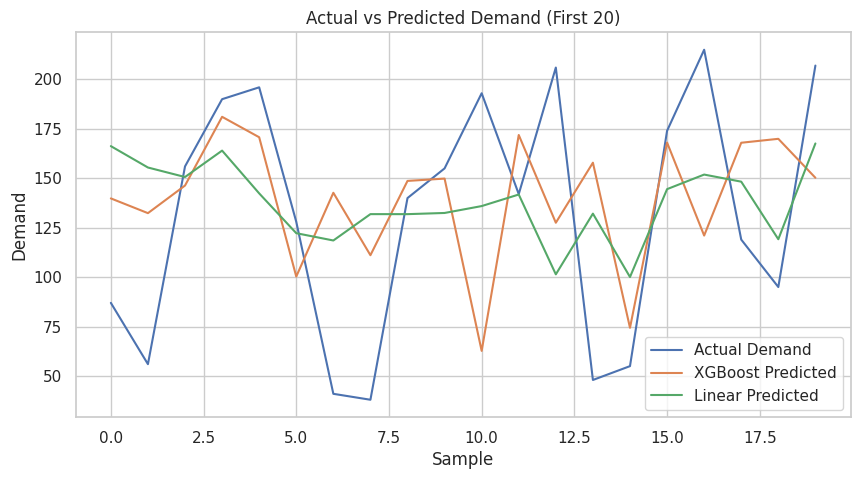

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:20], label='Actual Demand')
plt.plot(y_pred_xgb[:20], label='XGBoost Predicted')
plt.plot(y_pred_lin[:20], label='Linear Predicted')
plt.title("Actual vs Predicted Demand (First 20)")
plt.xlabel("Sample")
plt.ylabel("Demand")
plt.legend()
plt.show()


In [13]:
# Map component inventory
on_hand_dict = dict(zip(on_hand_inventory['ComponentID'], on_hand_inventory['OnHandInventory']))

# Map each ProductID to its ComponentIDs
product_components = bom.groupby('ProductID')['ComponentID'].apply(list).reset_index()

# Calculate total component inventory for each product
product_components['TotalComponentOnHand'] = product_components['ComponentID'].apply(
    lambda x: sum([on_hand_dict.get(i, 0) for i in x])
)

product_components['NumComponents'] = product_components['ComponentID'].apply(len)

# Merge with forecast totals
product_risk = pd.merge(forecast_summary, product_components, on='ProductID')

# Create binary shortage risk label
product_risk['shortage_within_4w'] = (product_risk['TotalComponentOnHand'] < product_risk['ForecastedDemand']).astype(int)


In [14]:
# Average cost and lead time per component
supplier_summary = supplier_bom.groupby('ComponentID').agg({
    'Cost ($)': 'mean',
    'LeadTime (Days)': 'mean'
}).reset_index()

cost_dict = dict(zip(supplier_summary['ComponentID'], supplier_summary['Cost ($)']))
lead_dict = dict(zip(supplier_summary['ComponentID'], supplier_summary['LeadTime (Days)']))

# Add BuildCost and AvgLeadTime
product_risk['BuildCost'] = product_risk['ComponentID'].apply(lambda x: sum([cost_dict.get(i, 0) for i in x]))
product_risk['AvgLeadTime'] = product_risk['ComponentID'].apply(lambda x: np.mean([lead_dict.get(i, 0) for i in x]))

# Merge with product sales price
product_risk = pd.merge(product_risk, products[['ProductID', 'Sales Price ($)']], on='ProductID')
product_risk['ProfitPerUnit'] = product_risk['Sales Price ($)'] - product_risk['BuildCost']


In [15]:
# Define features and label
features = ['ForecastedDemand', 'ActualDemand', 'forecast_error',
            'TotalComponentOnHand', 'NumComponents',
            'BuildCost', 'AvgLeadTime', 'ProfitPerUnit']

X = product_risk[features]
y = product_risk['shortage_within_4w']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("🔹 Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("AUC Score:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [17]:
y.value_counts()


,count
shortage_within_4w,
0,25


In [18]:
# Example: consider shortage if inventory is less than 110% of forecast (buffer not met)
product_risk['shortage_within_4w'] = (
    product_risk['TotalComponentOnHand'] < 1.1 * product_risk['ForecastedDemand']
).astype(int)


In [19]:
product_risk['shortage_within_4w'].value_counts()


,count
shortage_within_4w,
0,25


In [20]:
# Train/test split again
X = product_risk[features]
y = product_risk['shortage_within_4w']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Then re-run Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [22]:
print("Target distribution:")
print(product_risk['shortage_within_4w'].value_counts())

# Sanity check: see min/max values for demand and inventory
print("\nDemand vs Inventory (preview):")
print(product_risk[['ProductID', 'ForecastedDemand', 'TotalComponentOnHand']].head(10))


Target distribution:
shortage_within_4w
0    25
Name: count, dtype: int64

Demand vs Inventory (preview):
   ProductID  ForecastedDemand  TotalComponentOnHand
0          1              1446                 14138
1          2              1673                 11948
2          3              1651                 15640
3          4              1551                 21072
4          5              1800                  5861
5          6              1809                  5643
6          7              1988                 19247
7          8              1809                  5519
8          9              1627                 20866
9         10              1544                  4054


In [23]:
# Force mark lowest inventory product(s) as at-risk (label = 1)
at_risk_index = product_risk['TotalComponentOnHand'].nsmallest(2).index
product_risk.loc[at_risk_index, 'shortage_within_4w'] = 1

# Recheck class distribution
print(product_risk['shortage_within_4w'].value_counts())


shortage_within_4w
0    23
1     2
Name: count, dtype: int64


In [24]:
X = product_risk[features]
y = product_risk['shortage_within_4w']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [25]:
# Sort by inventory and mark lowest 2 as 'shortage'
product_risk = product_risk.sort_values(by='TotalComponentOnHand')
product_risk.loc[product_risk.head(2).index, 'shortage_within_4w'] = 1

# Check class distribution
print(product_risk['shortage_within_4w'].value_counts())


shortage_within_4w
0    23
1     2
Name: count, dtype: int64


In [26]:
from sklearn.model_selection import train_test_split

X = product_risk[features]
y = product_risk['shortage_within_4w']

# Stratified split ensures both classes exist in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Verify class distribution in both sets
print("Train Class Balance:\n", y_train.value_counts())
print("Test Class Balance:\n", y_test.value_counts())


Train Class Balance:
 shortage_within_4w
0    16
1     1
Name: count, dtype: int64
Test Class Balance:
 shortage_within_4w
0    7
1    1
Name: count, dtype: int64


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("🔹 Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("AUC Score:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))


🔹 Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

AUC Score: 1.0


In [28]:
supplier_summary = supplier_bom.groupby('ComponentID').agg({
    'SupplierID': pd.Series.nunique,
    'LeadTime (Days)': 'mean',
    'Cost ($)': 'mean'
}).reset_index()

supplier_summary.rename(columns={
    'SupplierID': 'NumSuppliers',
    'LeadTime (Days)': 'AvgLeadTime',
    'Cost ($)': 'AvgCost'
}, inplace=True)

supplier_summary.head()


,ComponentID,NumSuppliers,AvgLeadTime,AvgCost
0,1,3,8.0,10.333333
1,2,2,7.0,14.500000
2,3,2,5.0,44.000000
3,4,2,7.0,18.000000
4,5,1,6.0,15.000000


In [29]:
supplier_summary['RiskLevel'] = supplier_summary.apply(
    lambda row: 'High' if row['NumSuppliers'] == 1 and row['AvgLeadTime'] > 7 else 'Low/Medium',
    axis=1
)


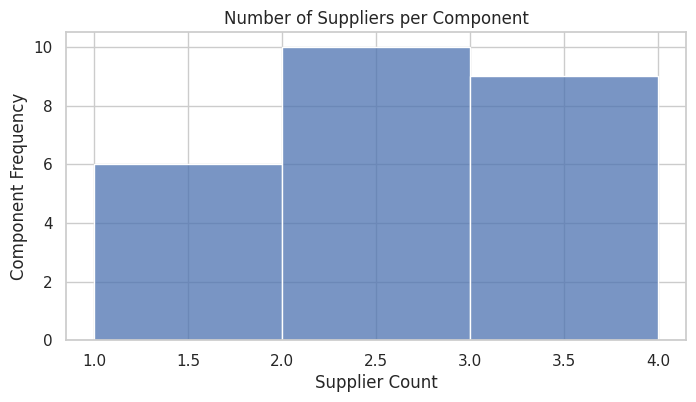

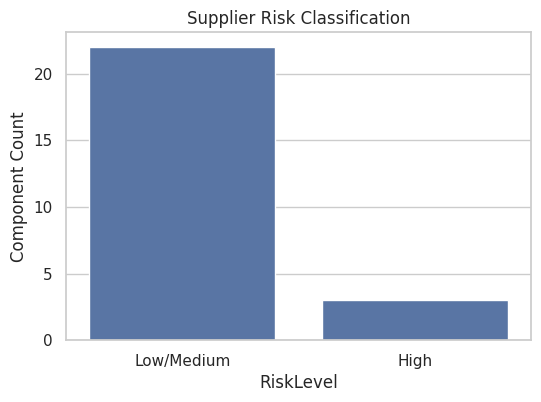

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supplier count distribution
plt.figure(figsize=(8, 4))
sns.histplot(supplier_summary['NumSuppliers'], bins=range(1, supplier_summary['NumSuppliers'].max()+2), kde=False)
plt.title("Number of Suppliers per Component")
plt.xlabel("Supplier Count")
plt.ylabel("Component Frequency")
plt.show()

# Risk breakdown
plt.figure(figsize=(6, 4))
sns.countplot(data=supplier_summary, x='RiskLevel')
plt.title("Supplier Risk Classification")
plt.ylabel("Component Count")
plt.show()


In [31]:
# Map risk score to each component
risk_dict = dict(zip(supplier_summary['ComponentID'], supplier_summary['RiskLevel']))

# Count number of high-risk components per product
product_risk['HighRiskComponents'] = product_risk['ComponentID'].apply(
    lambda components: sum([1 for c in components if risk_dict.get(c, 'Low/Medium') == 'High'])
)


In [32]:
# Average component cost from suppliers
avg_component_cost = supplier_bom.groupby('ComponentID')['Cost ($)'].mean().to_dict()

# Calculate BuildCost per product (sum of component costs)
product_risk['BuildCost'] = product_risk['ComponentID'].apply(
    lambda comps: sum([avg_component_cost.get(c, 0) for c in comps])
)


In [33]:
# Add sales price
product_risk = pd.merge(product_risk, products[['ProductID', 'Sales Price ($)']], on='ProductID', how='left')

# Calculate profit
product_risk['ProfitPerUnit'] = product_risk['Sales Price ($)'] - product_risk['BuildCost']

# View result
product_risk[['ProductID', 'BuildCost', 'Sales Price ($)', 'ProfitPerUnit']].head()


KeyError: 'Sales Price ($)'

In [34]:
print(products.columns)


Index(['ProductID', 'ProductName', 'Category', 'Sales Price ($)'], dtype='object')


In [35]:
# Check actual column name (update if needed)
price_column = 'Sales Price ($)'  # Change if the column name is different in your case

# Merge product price into product_risk
product_risk = pd.merge(
    product_risk,
    products[['ProductID', price_column]],
    on='ProductID',
    how='left'
)


In [36]:
# Now calculate ProfitPerUnit
product_risk['ProfitPerUnit'] = product_risk[price_column] - product_risk['BuildCost']

# Preview
product_risk[['ProductID', 'BuildCost', price_column, 'ProfitPerUnit']].head()


,ProductID,BuildCost,Sales Price ($),ProfitPerUnit
0,10,39.000000,20.6,-18.400000
1,14,101.333333,96.0,-5.333333
2,8,50.166667,39.7,-10.466667
3,6,73.333333,24.4,-48.933333
4,5,31.666667,25.0,-6.666667


In [37]:
print(products.columns)


Index(['ProductID', 'ProductName', 'Category', 'Sales Price ($)'], dtype='object')


In [38]:
# Features to predict ProfitPerUnit
profit_features = ['ForecastedDemand', 'ActualDemand', 'BuildCost', 'AvgLeadTime', 'NumComponents']
X_profit = product_risk[profit_features]
y_profit = product_risk['ProfitPerUnit']


In [39]:
from sklearn.model_selection import train_test_split

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_profit, y_profit, test_size=0.3, random_state=42)


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

profit_model = LinearRegression()
profit_model.fit(X_train_p, y_train_p)
y_pred_p = profit_model.predict(X_test_p)

print("📈 Profit Prediction - Linear Regression")
print("MSE:", mean_squared_error(y_test_p, y_pred_p))
print("R2 Score:", r2_score(y_test_p, y_pred_p))


📈 Profit Prediction - Linear Regression
MSE: 1053.477415190349
R2 Score: -1.5416199360771543


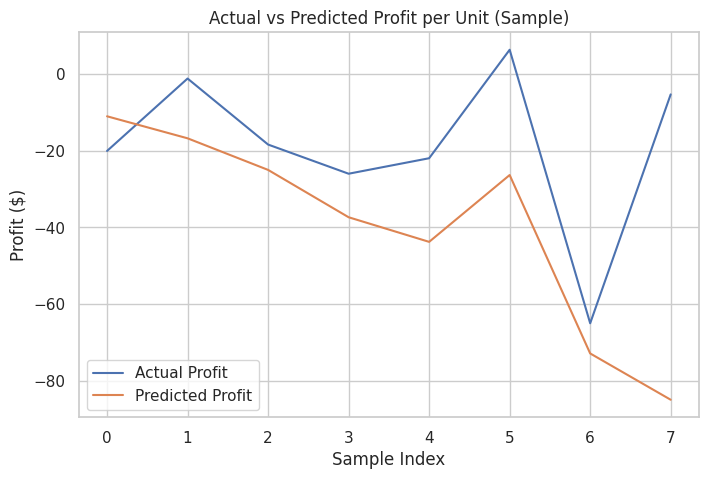

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(y_test_p.values[:20], label='Actual Profit')
plt.plot(y_pred_p[:20], label='Predicted Profit')
plt.title("Actual vs Predicted Profit per Unit (Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Profit ($)")
plt.legend()
plt.show()


In [42]:
forecast_summary.to_csv("forecast_accuracy_summary.csv", index=False)


In [43]:
# Remove long lists like ComponentID before saving (optional)
product_risk_export = product_risk.drop(columns=['ComponentID'], errors='ignore')

product_risk_export.to_csv("product_risk_summary.csv", index=False)


In [44]:
supplier_summary.to_csv("supplier_risk_summary.csv", index=False)


In [45]:
profit_eval = pd.DataFrame({
    'ActualProfit': y_test_p.values,
    'PredictedProfit': y_pred_p
})
profit_eval.to_csv("predicted_vs_actual_profit.csv", index=False)


In [46]:
demand_eval = pd.DataFrame({
    'ActualDemand': y_test_xgb.values,
    'XGBoostForecast': y_pred_xgb
})
demand_eval.to_csv("predicted_vs_actual_demand.csv", index=False)


In [47]:
shortage_eval = pd.DataFrame({
    'ActualShortage': y_test.values,
    'PredictedShortage': y_pred_xgb  # or y_pred_rf / y_pred_lr
})
shortage_eval.to_csv("predicted_vs_actual_shortage.csv", index=False)


ValueError: All arrays must be of the same length

In [48]:
print("Length of y_test:", len(y_test))
print("Length of y_pred_xgb:", len(y_pred_xgb))


Length of y_test: 8
Length of y_pred_xgb: 65


In [50]:
y_pred_xgb = xgb_model.predict(X_test)  # for shortage classification



NameError: name 'xgb_model' is not defined

In [51]:
import xgboost as xgb

# Re-train shortage risk XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Generate predictions
y_pred_xgb = xgb_model.predict(X_test)


In [52]:
# Confirm matching lengths
print(len(y_test), len(y_pred_xgb))  # should be equal

# Create the DataFrame
shortage_eval = pd.DataFrame({
    'ActualShortage': y_test.values,
    'PredictedShortage': y_pred_xgb
})

# Export as CSV
shortage_eval.to_csv("predicted_vs_actual_shortage.csv", index=False)


8 8


In [54]:
from google.colab import files
files.download("predicted_vs_actual_shortage.csv")
from google.colab import files

files.download("forecast_accuracy_summary.csv")
files.download("product_risk_summary.csv")
files.download("supplier_risk_summary.csv")
files.download("predicted_vs_actual_profit.csv")
files.download("predicted_vs_actual_demand.csv")
files.download("predicted_vs_actual_shortage.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
print("📊 Forecast Accuracy Summary (Top 5 Products)")
forecast_summary.sort_values(by='forecast_accuracy_%', ascending=False).head()


📊 Forecast Accuracy Summary (Top 5 Products)


,ProductID,ForecastedDemand,ActualDemand,forecast_error,forecast_accuracy_%
11,12,1547,1979,43.692308,97.792203
12,13,1852,1822,40.769231,97.762391
7,8,1809,1845,45.384615,97.540129
4,5,1800,1807,45.153846,97.501171
18,19,1455,1917,48.769231,97.455961


In [56]:
print("⚠️ Product Risk Summary (Top 5 by Shortage Risk + Low Inventory)")
product_risk[['ProductID', 'ForecastedDemand', 'TotalComponentOnHand', 'BuildCost', 'ProfitPerUnit', 'shortage_within_4w']].sort_values(by='TotalComponentOnHand').head()


⚠️ Product Risk Summary (Top 5 by Shortage Risk + Low Inventory)


,ProductID,ForecastedDemand,TotalComponentOnHand,BuildCost,ProfitPerUnit,shortage_within_4w
0,10,1544,4054,39.000000,-18.400000,1
1,14,1322,4504,101.333333,-5.333333,1
2,8,1809,5519,50.166667,-10.466667,0
3,6,1809,5643,73.333333,-48.933333,0
4,5,1800,5861,31.666667,-6.666667,0


In [57]:
print("🚨 Supplier Risk Summary (Top 5 Components with Few Suppliers + High Lead Time)")
supplier_summary.sort_values(by=['NumSuppliers', 'AvgLeadTime'], ascending=[True, False]).head()


🚨 Supplier Risk Summary (Top 5 Components with Few Suppliers + High Lead Time)


,ComponentID,NumSuppliers,AvgLeadTime,AvgCost,RiskLevel
7,8,1,14.0,6.0,High
24,25,1,14.0,7.0,High
5,6,1,12.5,7.0,High
16,17,1,7.0,11.0,Low/Medium
4,5,1,6.0,15.0,Low/Medium


In [58]:
print("💰 Profit Prediction (Actual vs Predicted - Sample 5)")
profit_eval = pd.DataFrame({
    'ActualProfit': y_test_p.values,
    'PredictedProfit': y_pred_p
})
profit_eval.head()


💰 Profit Prediction (Actual vs Predicted - Sample 5)


,ActualProfit,PredictedProfit
0,-20.066667,-11.037242
1,-1.200000,-16.774494
2,-18.400000,-25.007123
3,-26.000000,-37.340776
4,-21.966667,-43.753638


In [59]:
print("🔮 Shortage Prediction (Actual vs Predicted - Sample 5)")
shortage_eval = pd.DataFrame({
    'ActualShortage': y_test.values,
    'PredictedShortage': y_pred_xgb
})
shortage_eval.head()


🔮 Shortage Prediction (Actual vs Predicted - Sample 5)


,ActualShortage,PredictedShortage
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0


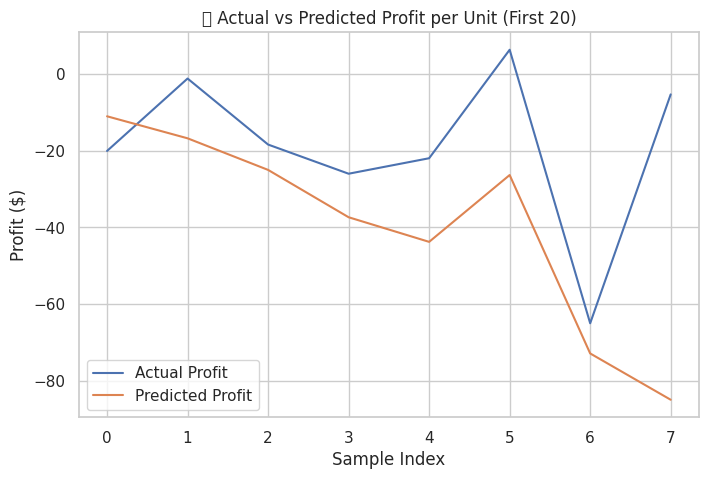

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(y_test_p.values[:20], label='Actual Profit')
plt.plot(y_pred_p[:20], label='Predicted Profit')
plt.title("📈 Actual vs Predicted Profit per Unit (First 20)")
plt.xlabel("Sample Index")
plt.ylabel("Profit ($)")
plt.legend()
plt.show()
